In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier

In [3]:
data=pd.read_csv("archive/Pokemon.csv")

In [4]:
data

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,719,Diancie,Rock,Fairy,600,50,100,150,100,150,50,6,True
796,719,DiancieMega Diancie,Rock,Fairy,700,50,160,110,160,110,110,6,True
797,720,HoopaHoopa Confined,Psychic,Ghost,600,80,110,60,150,130,70,6,True
798,720,HoopaHoopa Unbound,Psychic,Dark,680,80,160,60,170,130,80,6,True


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB


In [6]:
data.fillna("None", inplace=True)
data['Mega_Evolution']=np.where(data['Name'].str.contains('Mega'), 'Yes', 'No')
data.drop(['#','Name'], axis=1, inplace=True)

In [7]:
data

,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Mega_Evolution
0,Grass,Poison,318,45,49,49,65,65,45,1,False,No
1,Grass,Poison,405,60,62,63,80,80,60,1,False,No
2,Grass,Poison,525,80,82,83,100,100,80,1,False,No
3,Grass,Poison,625,80,100,123,122,120,80,1,False,Yes
4,Fire,None,309,39,52,43,60,50,65,1,False,No
...,...,...,...,...,...,...,...,...,...,...,...,...
795,Rock,Fairy,600,50,100,150,100,150,50,6,True,No
796,Rock,Fairy,700,50,160,110,160,110,110,6,True,Yes
797,Psychic,Ghost,600,80,110,60,150,130,70,6,True,No
798,Psychic,Dark,680,80,160,60,170,130,80,6,True,No


In [8]:
categorical_cols = ['Type 1', 'Type 2', 'Legendary']
data[categorical_cols] = data[categorical_cols].astype(str) 

encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_features = encoder.fit_transform(data[categorical_cols])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_cols))
data = data.drop(columns=categorical_cols).reset_index(drop=True)
data = pd.concat([data, encoded_df], axis=1)
data['Mega_Evolution'] = data['Mega_Evolution'].map({'No': 0, 'Yes': 1})

In [9]:
X = data.drop(columns=['Mega_Evolution'])
y=data['Mega_Evolution']

In [10]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [11]:
print(" y train distribution:\n", y_train.value_counts())
print("y test distribution:\n", y_test.value_counts())

 y train distribution:
 Mega_Evolution
0    601
1     39
Name: count, dtype: int64
y test distribution:
 Mega_Evolution
0    150
1     10
Name: count, dtype: int64


In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
svm = SVC(kernel='linear', C=10000, class_weight='balanced')
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

In [14]:
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))

SVM Accuracy: 0.95625


In [15]:
rf = RandomForestClassifier(n_estimators=500, max_depth=20, class_weight='balanced', random_state=42)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [16]:
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

Random Forest Accuracy: 0.95625


In [17]:
xgb = XGBClassifier(scale_pos_weight=15, n_estimators=300, max_depth=10, random_state=42)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
print("\nXGBoost Accuracy:", accuracy_score(y_test, xgb_pred))


XGBoost Accuracy: 0.9875


In [18]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, xgb_pred))
print(classification_report(y_test, xgb_pred))

[[150   0]
 [  2   8]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       150
           1       1.00      0.80      0.89        10

    accuracy                           0.99       160
   macro avg       0.99      0.90      0.94       160
weighted avg       0.99      0.99      0.99       160



In [19]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

[[149   1]
 [  6   4]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       150
           1       0.80      0.40      0.53        10

    accuracy                           0.96       160
   macro avg       0.88      0.70      0.76       160
weighted avg       0.95      0.96      0.95       160



In [20]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

[[146   4]
 [  3   7]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       150
           1       0.64      0.70      0.67        10

    accuracy                           0.96       160
   macro avg       0.81      0.84      0.82       160
weighted avg       0.96      0.96      0.96       160



In [22]:
cm_xgb = confusion_matrix(y_test, xgb_pred)

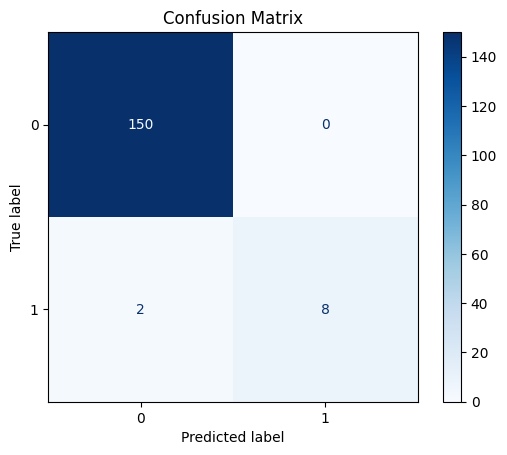

In [24]:
ConfusionMatrixDisplay(cm_xgb).plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [26]:
y_scores_xgb = xgb.predict_proba(X_test)[:, 1]


In [27]:
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_scores_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

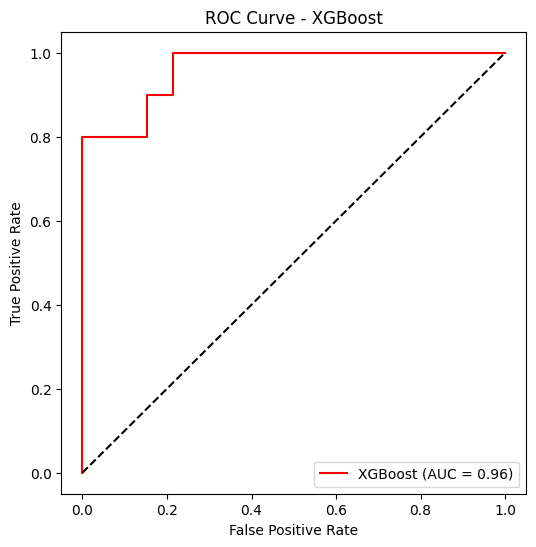

In [28]:
plt.figure(figsize=(6,6))
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {roc_auc_xgb:.2f})", color='red')
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend()
plt.show()

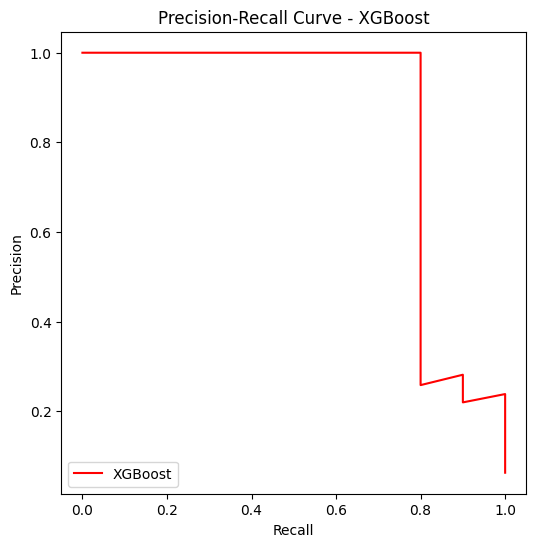

In [29]:
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_scores_xgb)
plt.figure(figsize=(6,6))
plt.plot(recall_xgb, precision_xgb, label="XGBoost", color='red')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - XGBoost")
plt.legend()
plt.show()